<center>
<h1>  Predict Bike Rental Demand </h1>  

<h3>  By: Branko Vanjorek <h3> 

## Overview

In this notebook, I will apply some popular machine learning techniques to the problem of predicting bike rental demand. The data set that will be used will be the records of bike rentals in Seoul, collected during 2017-18.

The main aims of the task is to: 

- to visualise data in several ways and check for common errors,
- to plan a simple experiment and prepare the data accordingly,
- to run an experiment and to report and interpret results clearly and concisely.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import pandas as pd
assert pd.__version__ >= "1.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Step 1: Load and pre-process the data set

In [2]:
data = pd.read_csv('SeoulBikeData.csv')
data.head()

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
data.describe()

,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature (C)            8760 non-null   float64
 4   Humidity (%)               8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature (C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

In [5]:
data.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature (C)              0
Humidity (%)                 0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature (C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

We want to predict future bike rental demand from this data. Hence our target feature is "Bike Rental Count". We will use regression techniques to do this, but this requires that our other features are numerical.

**How many samples are included in the data set?**

There are 8760 samples in the dataset.

**Are there any missing or invalid values in the data?**

No. data.isnull().sum() returns 0 for all features.
Additionally according to https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand there are no missing values.

**Are any features not numerical? If so, which ones?**

Yes there are non-numerical features. These include: Date, Seasons, Holiday, and Functioning Day.

### 1.2 Functioning days

The "Functioning day" feature records whether the bike rental was open for business on that day. We are only interested in predicting demand on days when the business is open, so remove rows from the DataFrame where the business is closed. 

In [6]:
#Checking the unquie entries of the 'Functioning Day' feature
data['Functioning Day'].unique()

array(['Yes', 'No'], dtype=object)

In [8]:
#Check how many rows have 'No' in Fucntioning Day feature
data.loc[(data['Functioning Day'] == 'No')]

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
3144,11/04/2018,0,0,14.4,82,4.6,1041,11.3,0.0,0.0,0.0,Spring,No Holiday,No
3145,11/04/2018,0,1,13.6,81,3.6,886,10.3,0.0,0.0,0.0,Spring,No Holiday,No
3146,11/04/2018,0,2,12.7,80,3.9,885,9.3,0.0,0.0,0.0,Spring,No Holiday,No
3147,11/04/2018,0,3,11.6,81,3.1,687,8.4,0.0,0.0,0.0,Spring,No Holiday,No
3148,11/04/2018,0,4,10.2,83,3.5,554,7.4,0.0,0.0,0.0,Spring,No Holiday,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8251,09/11/2018,0,19,11.9,71,2.7,589,6.7,0.0,0.0,0.0,Autumn,No Holiday,No
8252,09/11/2018,0,20,11.9,72,2.5,526,7.0,0.0,0.0,0.0,Autumn,No Holiday,No
8253,09/11/2018,0,21,11.4,74,1.9,498,6.9,0.0,0.0,0.0,Autumn,No Holiday,No
8254,09/11/2018,0,22,11.2,75,1.7,478,6.9,0.0,0.0,0.0,Autumn,No Holiday,No


*Note that the number of rows show above are the number of samples where the Functioning Day feature is 'No'*

In [9]:
#Create a new dataframe that is the same as the old dataframe, 
#but with entries that do not include when Functioning Day is 'No'
data = data[data['Functioning Day'] != 'No']
data

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday,Yes
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday,Yes
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday,Yes


In [10]:
#Check that our new data set only contains 'Yes' under the Functioning Day feature
data['Functioning Day'].unique()

array(['Yes'], dtype=object)

In [11]:
#Now remove the functioning day feature.
data = data.drop(['Functioning Day'], axis = 1)
data

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,Autumn,No Holiday
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,Autumn,No Holiday
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,Autumn,No Holiday
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,Autumn,No Holiday


### 1.3 Holidays and seasons

The Holiday and Season features both contain potentially useful information, but they need to be converted to a numerical format. Write code to convert the Holiday feature to 0 or 1 from its current format. 

The Season feature is a little tricker. We could assign each season a number, but a better solution in this case is to add 4 new columns, each labelled by a season, and each storing 0 or 1 according to the season in each row. 

#### Replacing Holiday with 1 to represent 'holiday', and 0 to represnt 'No holiday'

In [12]:
data = data.replace('No Holiday', 0)

In [13]:
data = data.replace('Holiday', 1)

In [14]:
#Check to see that the new values in the Holiday feature are 0 and 1.
data.Holiday.unique()

array([0, 1], dtype=int64)

Note: One hot encoding is preferable over assigning each season a number because this way, all seasons are numercially equal and will be treated equally during the analysis. Alternatively if the seasons were assignmed 1,2,3,4 for each season, then it is possible that the season assigned to '4' will be treated four times more important than the season assigned to '1'.

In [15]:
#Convert the categorical variable 'season' into dummy variables 0 and 1.
seasons = pd.get_dummies(data['Seasons'])
seasons

,Autumn,Spring,Summer,Winter
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
8755,1,0,0,0
8756,1,0,0,0
8757,1,0,0,0
8758,1,0,0,0


In [16]:
#Drop the season feature from the data frame. The season dataframe created will replace the old season feature
data = data.drop(['Seasons'], axis=1)
data

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0


In [17]:
#combine data dataframe (with season dropped) and the new season dataframe
data = pd.concat([data, seasons], axis=1)
data

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Winter
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0,1,0,0,0
8756,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0,1,0,0,0
8757,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0,1,0,0,0
8758,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0,1,0,0,0


In [18]:
#reset the indicies of the dataframe to accuractely reflect the number of entries.
data = data.reset_index(drop=True)
data

,Date,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Winter
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,0,1
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,30/11/2018,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0,1,0,0,0
8461,30/11/2018,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0,1,0,0,0
8462,30/11/2018,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0,1,0,0,0
8463,30/11/2018,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0,1,0,0,0


### 1.4 Weekday or weekend?

Finally, let's look at the Date feature. Talking with the rental shop operator, you discover that the date is important because bike rentals depend strongly on whether it's a weekday or a weekend. We will therefore replace the Date feature with a Weekday feature that stores 0 or 1 depending on whether the date represents a weekend or weekday. 

In [20]:
# A procedure for converting a date into a 1 or 0. 
# The date will be 1 if it is a weekday, and 0
# if it is a weekend.
from datetime import date

# Create an empty list to store new date values
# This values will replace the date values in the dataframe.
new_date = []

#loop for each date in the 'Date' column of the dataframe
for i in range(len(data.Date)):
    
    # prepare the date to be converted to a 0 or 1
    x = data.Date[i]
    x = x.split("/")
    x = list(map(int, x))
    
    #convert the date to a 1 or 0 using the weekday function.
    new_date.append(date(x[2], x[1], x[0]).weekday())

In [25]:
# Drop the data column. It will be replaced with the new_date values calculated above
data.drop(data.columns[0], axis = 1, inplace = True)

In [27]:
# Add a new date column (it will be the last feature in the dataframe)
# that contains only 1 or 0. The order of features in the dataframe does
# not mater.
data[0] = new_date
data = data.rename(columns={0: "Date"})

In [28]:
# Check that the change was correctly made.
data

,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Winter,Date
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1,4
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1,4
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,0,0,1,4
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,0,0,1,4
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8460,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,0.0,0,1,0,0,0,4
8461,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,0.0,0,1,0,0,0,4
8462,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,0.0,0,1,0,0,0,4
8463,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,0,1,0,0,0,4


In [29]:
data.describe()

,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Winter,Date
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.00000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,729.156999,11.507029,12.771057,58.147194,1.725883,1433.873479,3.944997,0.567868,0.14912,0.077685,0.048198,0.228825,0.255168,0.260839,0.255168,3.009687
std,642.351166,6.920899,12.104375,20.484839,1.034281,609.051229,13.242399,0.868245,1.12554,0.444063,0.214198,0.420101,0.435982,0.439118,0.435982,2.008583
min,2.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,214.000000,6.000000,3.000000,42.000000,0.900000,935.000000,-5.100000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,542.000000,12.000000,13.500000,57.000000,1.500000,1690.000000,4.700000,0.010000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,1084.000000,18.000000,22.700000,74.000000,2.300000,2000.000000,15.200000,0.930000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.00000,8.800000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Rented Bike Count          8465 non-null   int64  
 1   Hour                       8465 non-null   int64  
 2   Temperature (C)            8465 non-null   float64
 3   Humidity (%)               8465 non-null   int64  
 4   Wind speed (m/s)           8465 non-null   float64
 5   Visibility (10m)           8465 non-null   int64  
 6   Dew point temperature (C)  8465 non-null   float64
 7   Solar Radiation (MJ/m2)    8465 non-null   float64
 8   Rainfall(mm)               8465 non-null   float64
 9   Snowfall (cm)              8465 non-null   float64
 10  Holiday                    8465 non-null   int64  
 11  Autumn                     8465 non-null   uint8  
 12  Spring                     8465 non-null   uint8  
 13  Summer                     8465 non-null   uint8

## Step 2: Visualise the data (15\%)

### 2.1 Histograms

To get an overall view of the data distribution, plot frequency histograms of each attribute in the data set.

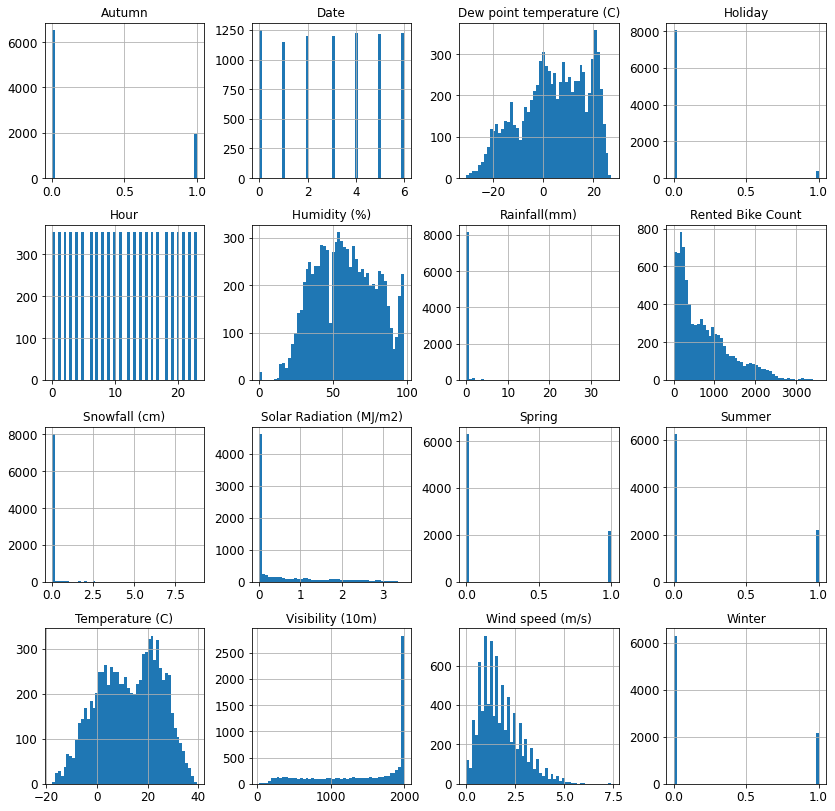

In [31]:
### Code to plot histogram for each feature

# bins = 50. Increase the value of bins to increase the resolution of the histograms.
hist = data.hist(figsize=(14,14), bins = 50)

**Observations:** The histograms show that the dataset contains a variety of distributions, as well as containing both discrete and continuous variables. 

The temperature and humidity seem to be symmetrically distributed. Furthermore there seems to be some bi-modality occuring in the Temperature feature.

The remaining features seem to be asymmetrically distributed. Windspeed, Rented Bike Count, Snowfall, Solar Radiation, and Rainfall are positively skewed. While Visibility is the only feature that is negatively skewed. This tells us that most of the values in these skewed features occur within a more narrow band of values, compared to the uniformly distributed features whose values are more uniformly spread out across a wider range.

Another interesting aspect to look at are the distributions with higher kurtosis. The histograms with higher kurtosis are the ones with 'higher peaks' and 'fatter tails'. Histograms that fit this description are: Rainfall, Snowfall, Solar Radiation, and Visibility. Since these distributions have higher kurtosis, it suggests that these features may contain outliers that are quite far away from the average value of the feature. These outliers may have an effect on the predictive power of the machine learning model, however it is not clear the effect will be positive or negative.

### 2.2 Correlation 

We are trying to predict the attribute "Bike Rental Count" from some combination of the other features. wE'LL Calculate the correlation of each feature with bike rentals.


In [32]:
### Your code here
data.corr()

,Rented Bike Count,Hour,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Autumn,Spring,Summer,Winter,Date
Rented Bike Count,1.000000,0.425256,0.562740,-0.201973,0.125022,0.212323,0.400263,0.273862,-0.128626,-0.151611,-0.070070,0.165333,0.015580,0.282001,-0.458920,-0.034272
Hour,0.425256,1.000000,0.122742,-0.235937,0.287780,0.103869,0.004691,0.144658,0.014345,-0.022082,-0.000229,0.001865,-0.000594,-0.000603,-0.000594,0.001006
Temperature (C),0.562740,0.122742,1.000000,0.166425,-0.038481,0.028262,0.914467,0.354844,0.052149,-0.217746,-0.057977,0.047283,0.012123,0.677872,-0.740433,-0.001287
Humidity (%),-0.201973,-0.235937,0.166425,1.000000,-0.337352,-0.548542,0.539402,-0.457273,0.236917,0.110127,-0.047796,0.023873,0.017463,0.198198,-0.240090,-0.007601
Wind speed (m/s),0.125022,0.287780,-0.038481,-0.337352,1.000000,0.180428,-0.177170,0.326222,-0.024931,-0.003789,0.031432,-0.123132,0.074645,-0.066895,0.111378,-0.028375
Visibility (10m),0.212323,0.103869,0.028262,-0.548542,0.180428,1.000000,-0.182586,0.153046,-0.170352,-0.122860,0.022210,0.111179,-0.185450,0.066203,0.011642,-0.027194
Dew point temperature (C),0.400263,0.004691,0.914467,0.539402,-0.177170,-0.182586,1.000000,0.098525,0.126812,-0.149760,-0.067625,0.049595,0.006471,0.664183,-0.723221,-0.011900
Solar Radiation (MJ/m2),0.273862,0.144658,0.354844,-0.457273,0.326222,0.153046,0.098525,1.000000,-0.074157,-0.073380,-0.001963,-0.028287,0.075799,0.132320,-0.181814,0.011503
Rainfall(mm),-0.128626,0.014345,0.052149,0.236917,-0.024931,-0.170352,0.126812,-0.074157,1.000000,0.008604,-0.013301,-0.015228,0.019671,0.055087,-0.060480,-0.021967
Snowfall (cm),-0.151611,-0.022082,-0.217746,0.110127,-0.003789,-0.122860,-0.149760,-0.073380,0.008604,1.000000,-0.012043,-0.017401,-0.102400,-0.103928,0.223842,-0.012421


**Observation:** The highest correlated features with Rented Bike count are: Temperature, Hour, and Winter (winter being negatively correlated). While the features that are the least correlated with Rented Bike Count are Spring, Date, and Holiday. 

## Plotting most correlated features as scatter plots 

In [33]:
#For plotting, Seaborn will be used 
import seaborn as sns 
# set Seaborn up as the default enviroment 
sns.set()

### Plotting Tempeature

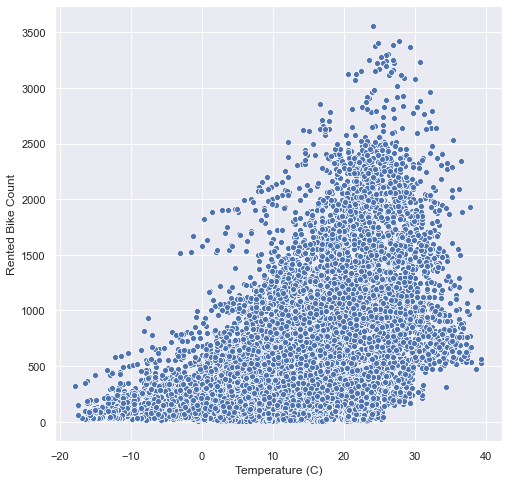

In [38]:
#We use the transpose to get two dimensions.
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(data['Temperature (C)'], data['Rented Bike Count'])
#Note: the Array printed as a out is the values of the axis to 
# have the adjust of the axis (previous line code)

**Observation:**
The temperature feauture looks like a positively skewed distriubution, with the mean centered around 23 degrees. This suggests that people are more willing to rent bikes when the temperature is around 23 degrees.

### Plotting Winter

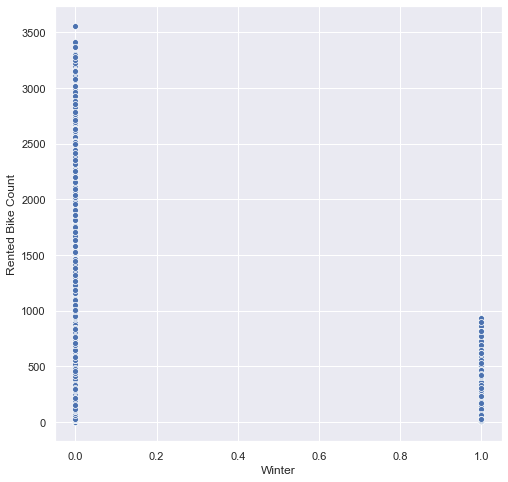

In [39]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(data['Winter'], data['Rented Bike Count'])

**Observation:**
The Winter feature was a higher negative correlation. The data suggests that people rent bikes when it is not winter.

### Plotting Hour

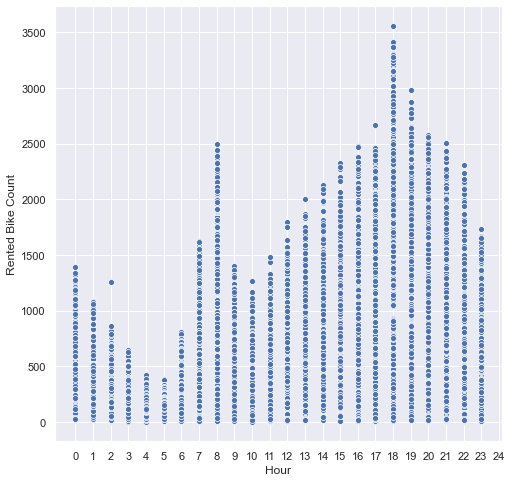

In [36]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(data['Hour'], data['Rented Bike Count'])
plt.xticks(np.arange(0, 24+1, 1))
plt.show()

**Observation:**
For the Hour feature, there seem to be 2 spike periods. One occurring between 7am and 9am, and another one occurring between 5pm and 7pm. This may be due to people renting bikes for going to and returning from work. It may suggest that a large number of bike rentals are due to practical purposes rather than recreational ones. 


Overall, it seems that people most like to rent bikes between the hours of 7am and 9am, and 5pm and 7pm when it is not winter and the temperature is around 23 degrees celsius. 

## Step 3: Predicting bike rentals: baseline (15\%)

We will approach prediction as a regression problem: that is, we will pretend that "bike rentals" is a real number whose value we want to predict.

We will use root mean square error (rmse) as our error function when evaluating our predictor:

$$rmse(h, y) = \sqrt { \frac{1}{m} \sum_{i=1}^{m} \left( h_i - y_i \right)^2}
$$

where $y_i$ is the actual value of the $i$th data point and $h_i$ is the value predicted by our model.

To perform prediction, we first need to split our data set into train and test sets. To start, do this by randomly selecting $20\%$ of the data as test data,  and use the remaining $80\%$ as training data.

Before we start training sophisticated models, it's useful to try a simple estimation method. This serves as a sanity check and provides a baseline performance against which to measure other models. We'll do this bey finding the mean bike rental value in your training set, and use that as the predicted value for every data point (ignoring all attributes).

In [42]:
### Your code here

#split data into training and test.
from sklearn.model_selection import train_test_split

# Randomly selects 20%  of the data as test data, and use the remaining  80%  as training data. 
Train, Test = train_test_split(data, random_state=42, test_size = 0.2)

In [43]:
# Create training labels (what we want to predict) - y_train
# and training features (what we will use for training) - X_train 
y_train = Train['Rented Bike Count']
X_train = Train.drop(['Rented Bike Count'], axis = 1)

In [44]:
# Create test labels (what we want to predict) - y_test
# and training features (what we will use for training) - X_test
y_test = Test['Rented Bike Count']
X_test = Test.drop(['Rented Bike Count'], axis = 1)

In [45]:
# Import relevant library for a dummy regressor
from sklearn.dummy import DummyRegressor

# Create a dummy regressor and set to mean
dummy_mean = DummyRegressor(strategy='mean')

# "Train" dummy regressor on the training set.
dummy_mean.fit(X_train, y_train)

DummyRegressor()

In [46]:
prediction = dummy_mean.predict(X_train)
prediction

array([731.39043119, 731.39043119, 731.39043119, ..., 731.39043119,
       731.39043119, 731.39043119])

Drawing a scatter plot (plt.scatter) with actual values on the x axis, and the residual at each point (i.e. predicted - actual) on the y axis.

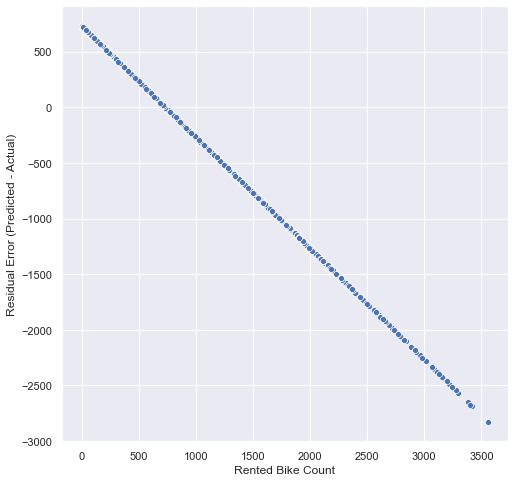

In [56]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, prediction - y_train)
plt.ylabel("Residual Error (Predicted - Actual)") 
plt.show()

**Question. Is this expected?**

**Answer:** Yes it is expected. The dummy regressor is only using the mean value of the target training values to predict Rented Bike Count. In other words, the dummy regression will only use a constant mean value to predict each point. It is this constant value that results in the linear graph shown above. 

For example, when we try and predict 0 with this dummy regressor, the regressor will use 731. The difference in values is 731, which is what is seen on the x and y axis, respectively. When we try and predict 731, the regressor will use 731, and therefore the difference in values is 0. Again this is shown on the graph. When we try and predict 1731, the regressor will use 731, which results in a difference in -1000. 

**Question:** What is the rmse for this predictor, when trained and tested on the training set? (Remember, the test set is not for use until later).



In [54]:
#Find the RMSE for the dummy predictor
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, prediction, squared=False)

646.170499547999

Considering the mean value for bike rental prediction is 729, an RMSE of 646 is considered poor.

## Step 4: Predicting bike rentals (20\%)

We will fit a *linear regression* model to the training data. The `LinearRegression` model in sklearn will enable this. To get an idea of how successful this model is, we'll apply it to the *training* data, plot the residuals as before, and calculate the rmse. 


## Linear Regression

In [57]:
### Your code here
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg_prediction = reg.predict(X_train)
reg_prediction

array([ 649.77097929, 1123.67122896, 1172.19137142, ..., 1203.432046  ,
        448.99122193,  674.90195515])

### Plotting the residuals

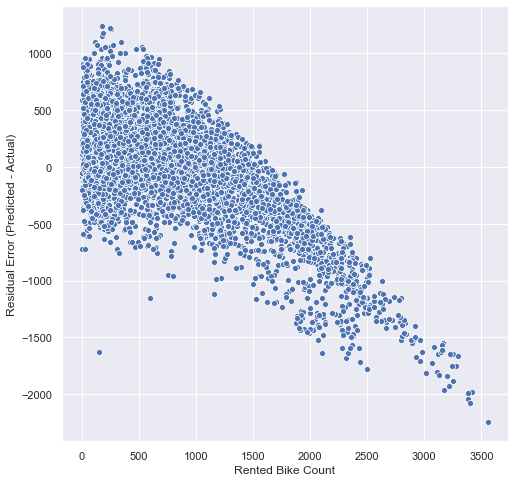

In [59]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, reg_prediction - y_train)
plt.ylabel("Residual Error (Predicted - Actual)") 
plt.show()

### Calculate the RMSE

In [60]:
mean_squared_error(y_train, reg_prediction, squared=False)

438.2217636295327

**Observation:**  This RMSE value is better that the dummy regressor, but its not a great improvement.

## K Nearest Neighbour

We'll fit a *k nearest neighbour* regression model to the training data, for varying values of k.

In [61]:
### Your code here
from sklearn.neighbors import KNeighborsRegressor
neigh_1 = KNeighborsRegressor(n_neighbors=1)
neigh_2 = KNeighborsRegressor(n_neighbors=2)
neigh_3 = KNeighborsRegressor(n_neighbors=3)
neigh_4 = KNeighborsRegressor(n_neighbors=4)
neigh_5 = KNeighborsRegressor(n_neighbors=5)

neigh_1.fit(X_train, y_train)
neigh_2.fit(X_train, y_train)
neigh_3.fit(X_train, y_train)
neigh_4.fit(X_train, y_train)
neigh_5.fit(X_train, y_train)
 
neigh_1_prediction = neigh_1.predict(X_train)
neigh_2_prediction = neigh_2.predict(X_train)
neigh_3_prediction = neigh_3.predict(X_train)
neigh_4_prediction = neigh_4.predict(X_train)
neigh_5_prediction = neigh_5.predict(X_train)
    

### Plot the residuals for each KNN model

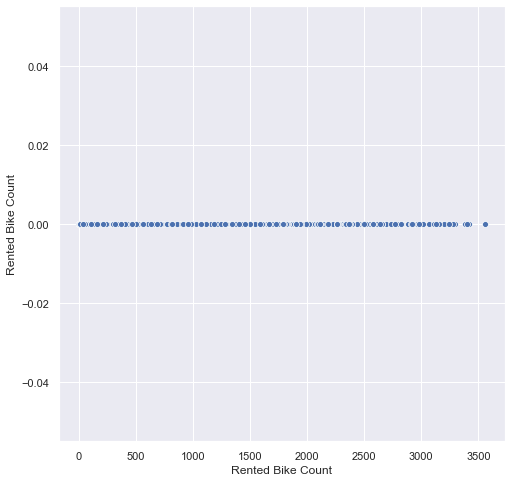

In [62]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, neigh_1_prediction - y_train)
plt.show()

In [63]:
mean_squared_error(y_train, neigh_1_prediction, squared=False)

0.0

**Observation:** The perfect error score above comes from the fact that k=1 means that the closest point to any training data point is itself.
This means the data is completely overfitted, and altough it performs perfectly on the training data, it is likely to perform poorly on the test data.

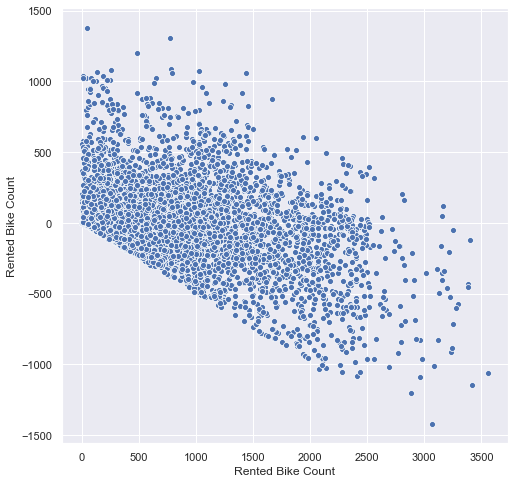

In [64]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, neigh_2_prediction - y_train)
plt.show()

In [65]:
mean_squared_error(y_train, neigh_2_prediction, squared=False)

250.18976192943222

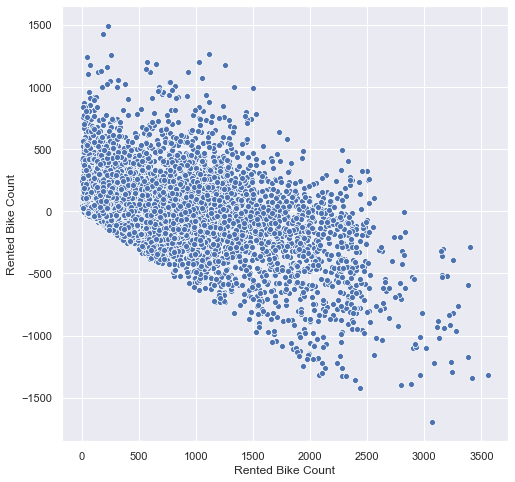

In [66]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, neigh_3_prediction - y_train)
plt.show()

In [67]:
mean_squared_error(y_train, neigh_3_prediction, squared=False)

296.7134666513287

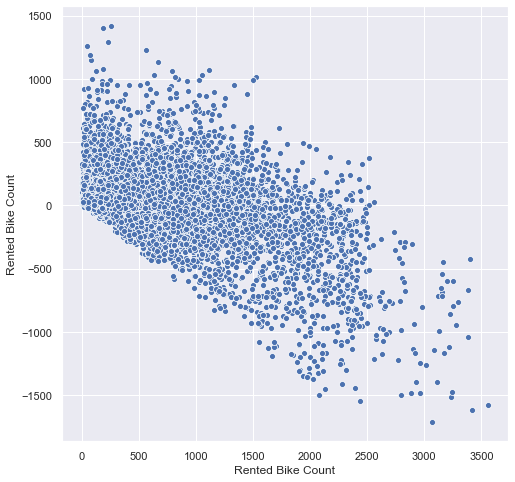

In [68]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, neigh_4_prediction - y_train)
plt.show()

In [69]:
mean_squared_error(y_train, neigh_4_prediction, squared=False)

314.23605013511514

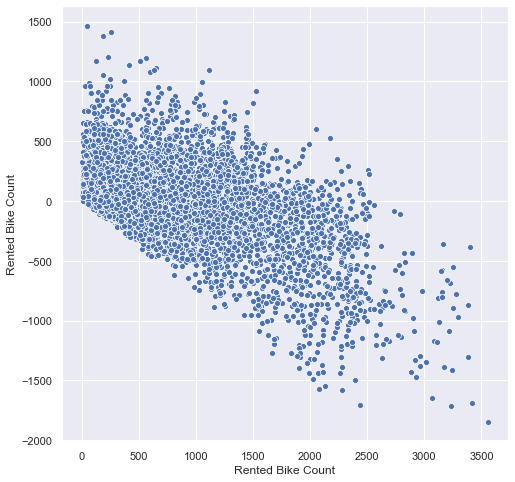

In [70]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, neigh_5_prediction - y_train)
plt.show()

In [71]:
mean_squared_error(y_train, neigh_5_prediction, squared=False)

325.6185667283547

**Observation:** From the KNN models created above, the best performing model (not considering when k=1 since this is completely overfitted) is the second model when k=2.

## Decision Trees

Finally, we'll fit a *decision tree* to the training data.

In [72]:
### Your code here

from sklearn.tree import DecisionTreeRegressor

decision_reg = DecisionTreeRegressor()

decision_reg.fit(X_train, y_train)
 
decision_prediction = decision_reg.predict(X_train)

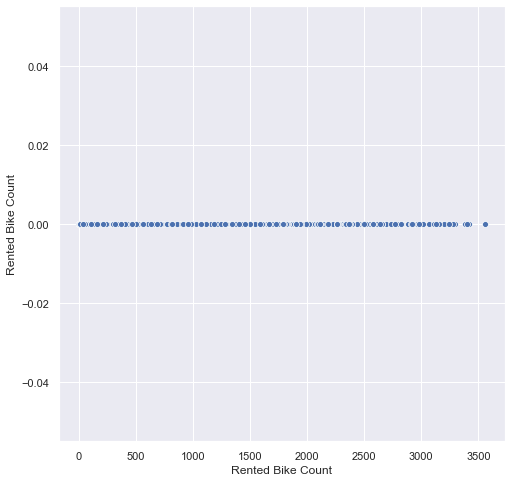

In [73]:
plt.figure(figsize=(8,8))

#Plotting with Seaborn
sns.scatterplot(y_train, decision_prediction - y_train)
plt.show()

In [74]:
mean_squared_error(y_train, decision_prediction, squared=False)

0.0

**Observation:** Similar to the KNN model when K=1, this model is completely overfitted. Over-fitting in decision trees occur when the tree is designed so as to perfectly fit all samples in the training data set. The tree ends up with branches with strict rules of sparse data. 

## Step 5: Cross validation (20\%)

At this point, we are still evaluating our models on the *training data* only. Achieving a low error on the the training data does not necessarily mean the model will perform well on the test data. For example, a powerful model with many parameters may overfit to the training data.

Cross validation lets us test our models by repeatedly splitting the training data into separate training and validation sets, and testing performance on "unseen" data in the validation set. We'll perform *10 fold cross validation* for each model. This splits the training set into 10 equal size subsets, and uses each in turn as the validation set while training a model with the other 9. We will therefore have 10 error values for each cross validation run.

We'll display the mean and standard deviation of the error values obtained for each model.

### CV for the Linear Regression Model

In [76]:
from sklearn.model_selection import cross_val_score

reg = LinearRegression()
scores = cross_val_score(reg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

#Calculating the mean score of the 10 validation results, as well as 1 standard deviation.
#This tells us that 68% of the data will be wuthin 1 standard deviations from the mean score.
print('mean:',scores.mean(), '(+/-', scores.std(),')')

mean: -439.40721377575227 (+/- 15.70144961104478 )


### CV for the KNN Models

In [79]:
neigh_1 = KNeighborsRegressor(n_neighbors=1)
neigh_2 = KNeighborsRegressor(n_neighbors=2)
neigh_3 = KNeighborsRegressor(n_neighbors=3)
neigh_4 = KNeighborsRegressor(n_neighbors=4)
neigh_5 = KNeighborsRegressor(n_neighbors=5)
neigh_6 = KNeighborsRegressor(n_neighbors=6)
neigh_7 = KNeighborsRegressor(n_neighbors=7)
neigh_8 = KNeighborsRegressor(n_neighbors=8)
neigh_9 = KNeighborsRegressor(n_neighbors=9)
neigh_10 = KNeighborsRegressor(n_neighbors=10)

neigh_models = [neigh_1, neigh_2, neigh_3, neigh_4, neigh_5, 
                neigh_6, neigh_7, neigh_8, neigh_9, neigh_10]
scores = []

for i in range(len(neigh_models)):
    scores = cross_val_score(neigh_models[i], X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
    print('model', i+1,':', 'mean:',scores.mean(), '(+/-', scores.std(),')')

model 1 : mean: -506.2391103969236 (+/- 23.277493913514206 )
model 2 : mean: -449.7478144267244 (+/- 13.138201122138371 )
model 3 : mean: -423.2445040052477 (+/- 11.735263693142517 )
model 4 : mean: -408.8335815634506 (+/- 12.555324890707828 )
model 5 : mean: -404.14440037131703 (+/- 12.178319337932612 )
model 6 : mean: -401.63231071687113 (+/- 10.832592374007872 )
model 7 : mean: -401.53095372892295 (+/- 13.231215722596534 )
model 8 : mean: -403.45171234943786 (+/- 13.74408639403262 )
model 9 : mean: -403.7535427209836 (+/- 13.626390437996186 )
model 10 : mean: -405.8884673806243 (+/- 13.448167059650102 )


**Observation:** The analysis above shows that model 6 performed the best. This is when the KNN modelled used k=6. Model 6 returned on of the lowest mean RMSE score with the smallest standard deviation.

Note that after k=6, the errors begin to increase again. Furthermore, model 1 performed the worst. Which is not unexpected since we had mentioned previously that this model was completely overfitted to the data.

### CV for the Decision Tree Model

In [84]:
decision_reg = DecisionTreeRegressor()
scores = cross_val_score(decision_reg, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
print('mean:',scores.mean(), '(+/-', scores.std(),')')

mean: -238.4622002232261 (+/- 20.462112178864583 )


**Observation:** Out of all the models trained, and by using cross validation, the best model (based on the lowest RMSE) seems to be the Decision Tree model.

## Step 6: Grid parameter search (10%)

Both the kNN and Decision Tree regressors have several hyperparameters that can be set to suit the problem. For either the kNN or Decision tree regressor (whichever you found more suitable), we'll use grid search to systematically compare the error obtained with different hyperparameter settings.

For the kNN regressor, vary settings for the `n_neighbors` and `weights` hyperparameters.
For the decision tree regressor, vary settings for the `max_depth` and `max_features` hyperparameters.

We'll print out the best hyperparameter settings for the best method. Finally, we'll apply the best method, with those parameter settings, to the *test set*. 

In [85]:
## Your code here
from sklearn.model_selection import GridSearchCV

# max features is a range between 1 and the maximum number of features in the dataset.
# max depth is a range between 1 and 20, with increments of 1
parameters = {'max_features':range(1, data.shape[1]-1, 1), 'max_depth':range(1, 20, 1)}
decision_reg = DecisionTreeRegressor()

grid = GridSearchCV(decision_reg, parameters, scoring='neg_root_mean_squared_error', cv=10)

grid

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 20),
                         'max_features': range(1, 15)},
             scoring='neg_root_mean_squared_error')

In [86]:
grid_result  = grid.fit(X_train, y_train)
grid_result

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 20),
                         'max_features': range(1, 15)},
             scoring='neg_root_mean_squared_error')

In [87]:
#Show the best parameters
grid_result.best_params_

{'max_depth': 13, 'max_features': 14}

In [88]:
# print prediction results 
import math

grid_predictions = grid_result.predict(X_test) 

RMSE = math.sqrt(mean_squared_error(y_test, grid_predictions))
print(RMSE)

247.1061533441435


**Observation:** A decision tree model was trained to predict Bike Rental Counts. The decision tree was selected because it had the lowest RMSE score after using cross validation, compared to a linear regression model, and several KNN models. Furthermore, two hyperparameters of the decision tree model were tuned using grid search. The hyperparameters included 'maximum features' and 'maximum depth'. The best values for these parameters were 14 and 13, respectively.

The tuned decision tree model was able to predict Bike Rental Count with a RMSE of 247. This error was not surprising, This is because the error fell within the error range provided by the CV method, which was 238.46 with a standard deviation of +- 20.46. This provides evidence that it is good practice to use CV in order to consistent results. 

To further improve the accuracy of the model, it may be worth investigating the effects of removing uncorrelated features from the dataset and determining if the model increases or decreases in accuracy. Furthermore, it was discovered in the data visualisation step that several features showed high kurtosis. This suggests the presence of outliers that are quite far away from the mean value of that feature. Therefore to further improve the model's accuracy, it may be worth investigating if removing these outliers will have any effect on the model's performance.